## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input

## Import Dataset

## 1. Data Preprocessing:
o Load the dataset and focus on the 'Close' price column, as this will be your target variable for prediction.  
o Normalize the data (e.g., using Min-Max scaling to keep values between 0 and 1).  
o Split the dataset into a training set (80%) and a testing set (20%).

In [3]:
# Load dataset (Assuming the dataset has 'Date' and 'Close' columns)
df = pd.read_csv('HistoricalQuotes.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Type conversion
df[' Close/Last'] = df[' Close/Last'].apply(lambda x: float(x[2:])).values.astype(float)
df[' Open'] = df[' Open'].apply(lambda x: float(x[2:])).values.astype(float)
df[' High'] = df[' High'].apply(lambda x: float(x[2:])).values.astype(float)
df[' Low'] = df[' Low'].apply(lambda x: float(x[2:])).values.astype(float)

# Focus on 'Close' price and use the rest as predictors
df = df[['Date', ' Close/Last']].sort_values('Date')
df.set_index('Date', inplace=True)

# Normalize the data (excluding the target 'Close' column)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[[' Close/Last']])

# Create the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

## 2. Create Training Sequences:  
o Convert the 'Close' prices into a series of sequences for training.  
o Define a sequence length (e.g., 60 days), where each sequence will be used to predict the stock price for the next day.

In [4]:
sequence_length = 60  # Use the last 60 days to predict the next day's price

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Sequence of 60 days
        y.append(data[i, 0])  # Predict next day's 'Close'
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 3. Build the RNN Model:  
o Define an RNN model with the following architecture:
 - An RNN layer with 50 units
 - A Dense layer with 1 unit (for regression output).   

o Use the mean squared error (MSE) loss function and the Adam optimizer.

In [5]:
model = Sequential(name = "RNN_Model_for_Stock_Prediction")
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dense(1))  # Output layer for regression
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "RNN_Model_for_Stock_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model:
o Train the model on the training set for 50 epochs with a batch size of 32.  
o Use validation data to check for overfitting.

In [6]:
# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0193 - val_loss: 0.0116
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9170e-04 - val_loss: 0.0053
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0816e-04 - val_loss: 0.0034
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6757e-05 - val_loss: 0.0034
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2609e-05 - val_loss: 0.0024
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5526e-05 - val_loss: 0.0020
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.7978e-05 - val_loss: 0.0016
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1374e-05 - val_loss: 0.0013
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7756e-05 - val_loss: 0.0011
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2308e-05 - val_loss: 6.7114e-04
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.3076e-05 - val_loss: 7.3199e-04
Epoch 12/50
62/

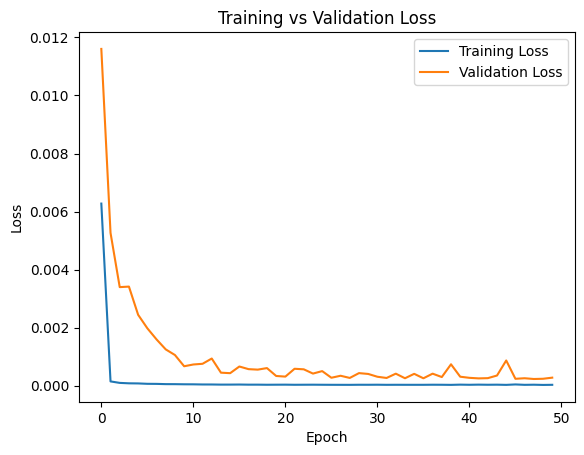

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Make Predictions:
o Predict the stock prices on the test set and transform the results back to the original scale if normalization was applied.  
o Plot the predicted vs. actual stock prices to visualize the model's
performance.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


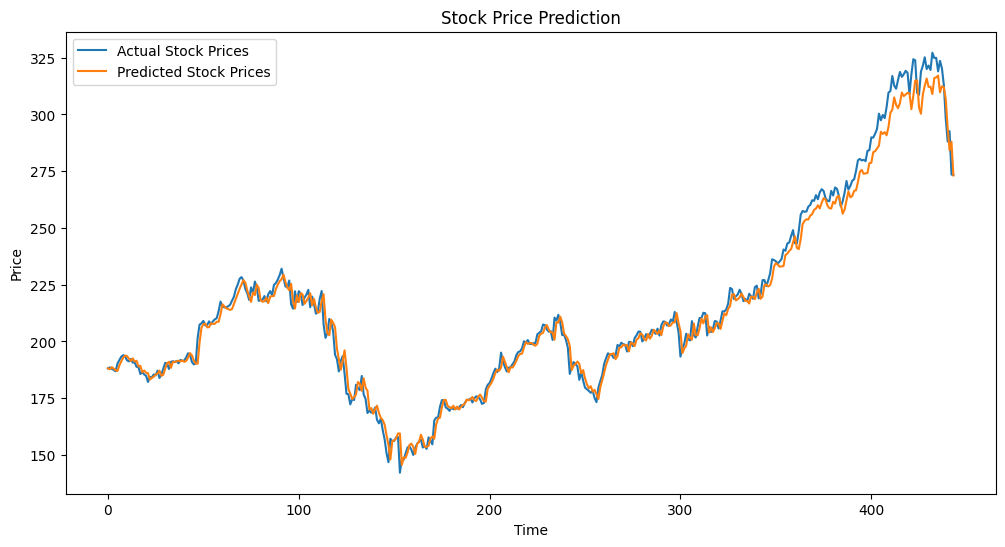

In [9]:
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values back to the original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions)

# Plot Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Stock Prices')
plt.plot(predictions_inv, label='Predicted Stock Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 6. Evaluation

In [10]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 3.5691153957607513
Root Mean Squared Error (RMSE): 4.960299160326055


1. Mean Absolute Error (MAE):
MAE measures the average magnitude of errors between predicted and actual values, without considering the direction of the errors (i.e., whether the model's predictions are above or below the true values).
The value of 3.99 means that, on average, the model's predictions were off by about \$3.99 from the actual stock price.

  Interpretation of MAE:  
  A lower MAE indicates better model performance because it means the model's predictions are closer to the actual values. In this case, the MAE value suggests that the model's predictions are reasonably accurate but there is still a significant gap. Whether this is acceptable depends on the volatility and price range of the stock we are predicting.

  For example, if we are predicting a stock whose prices fluctuate between \$100 and \$300, an MAE of \$3.99 might be acceptable in some cases. But if the stock price is much lower or more stable, such an error might be larger in proportion to the stock's price.  

2. Root Mean Squared Error (RMSE):
RMSE measures the square root of the average squared differences between predicted and actual values. It gives higher weight to larger errors, meaning it penalizes outliers or large mistakes more than MAE.
The value of 5.70 indicates that the typical deviation between the predicted stock price and the actual stock price is around $5.70.

  Interpretation of RMSE:  
  RMSE is more sensitive to large errors than MAE, so it can be considered a more "strict" metric. If there are significant outliers (i.e., periods when the model's prediction is way off), RMSE will penalize the model more heavily than MAE. A lower RMSE indicates a better fit, especially if the price variations of the stock are considerable. In this case, the RMSE of 5.70 suggests that, while the model is fairly close in its predictions, there is still room for improvement. Particularly, the model might be over-penalizing larger errors, or there might be periods with significant deviations between predicted and actual prices.

Overall Performance:  
- MAE = 3.99: This shows that, on average, the model's prediction error is about $3.99.

- RMSE = 5.70: This suggests that larger prediction errors have a disproportionate effect on the model's overall performance.  


The model seems to be performing reasonably well, but there is room for improvement. The following considerations might help improve the model's performance:
 - The current RNN model with 50 units may be too simple to capture the complexities of stock price movements
 - If the stock is highly volatile, it's natural for the model to have larger errors.
 - Stock price prediction is difficult because stock prices can be influenced by a large number of factors.